---
## GISalmon Prototype
---

# 1. Folium Map
### Requirements:

In [1]:
# Python Modules
import os
# Data Modules
import pandas
import geopandas as gpd
# Spatial Modules
import folium
import branca
from branca.element import Template, MacroElement 
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

### Global Variables:

In [2]:
cwd = os.getcwd()
path = 'static/assets/data/'
species = ['Chinook', 'Coho', 'Even_Year_Pink', 'Odd_Year_Pink', 'Lake_Type_Sockeye']
species_labels = ['Chinook Spawning Regions', 'Coho Spawning Regions', 'Even Year Pink Spawning Regions',
                  'Odd Year Pink Spawning Regions', 'Lake Type Sockeye Spawning Regions']
species_codes = ['CK', 'CO', 'PKE', 'PKO', 'SEL']

### Program Functions:

In [12]:
def create_layers():
    '''
        Create a folium GeoJson object from each set of input shapefiles (boundary+status)
        for each species.
            -> returns gjson: list of GeoJson objects
    '''
    gjson = []
    for i in range(0,len(species)):
        boundary_path = path+'{f}/{f}_Salmon_CU_Shape/{f}_Simple/{f}_Boundary_Simple.shp'.format(f=species[i])
        boundary = gpd.read_file(boundary_path)
        boundary = clean(boundary, species[i], 'B')

        status_path = path+'{f}/{f}_Salmon_CU_Shape/{f}_Salmon_CU_Status/{fc}_CU_STATUS_En.shp'.format(f=species[i], fc=species_codes[i])
        status = gpd.read_file(status_path)
        status = clean(status, species[i], 'S')

        merged = boundary.merge(status, on='CU_INDEX')
        merged['FISH'] = species[i]
        merged.crs = "EPSG:4326"

        json = merged.to_json()
        show = False
        if species[i] == 'Chinook':
            show = True
        gjson_obj = folium.features.GeoJson(json, 
                                            style_function, 
                                            name = species_labels[i],
                                            show = show,
                                            smooth_factor=1.5,
                                            tooltip = folium.features.GeoJsonTooltip(
                                                    fields=['CU_name','FISH', 'WSP_Status'],
                                                    aliases=['Conservation Unit:', 'Salmon Species:', 'WSP Status'],
                                                    style = ('background-color: grey; color: white; font-size: 10px; padding: 20px;')
                                                    )
                                           )   
        gjson.append(gjson_obj)

    return gjson

def clean(df, species, flag):
    '''
        Prepares datasets for mapping.
            -> returns df: geo dataframe of boundary or status shapefile    
    '''
    # Clean Boundary Shapefile and remove uneccesary attributes
    if flag == 'B':
        if species == 'Chinook':
            df = df.rename(columns={'CU_NAME': 'CU_name', 'FULL_CU_IN':'CU_INDEX'})
        if species == 'Coho':
            df = df.rename(columns={'Full_CU_IN': 'CU_INDEX'})
        attrs = ['CU_name', 'CU_INDEX', 'geometry']
        df = df[attrs] 
    # Clean Status Shapefile and remove uneccesary attributes      
    if flag == 'S':
        if species == 'Chinook':
            df = df.rename(columns={'CU_NAME': 'CU_name', 'WSP_STATUS':'WSP_Status'})
        if species == 'Coho':
            df = df.rename(columns={'Full_CU_IN': 'CU_INDEX'})
        attrs = ['CU_INDEX', 'WSP_Status']
        df = df[attrs]

    return df

def style_function(feature):
    '''
        Style function for folium GeoJson objects.
            -> returns style: dictionary of style options    
    '''
    # default style
    style = {
            'fillOpacity': 0.75,
            'weight': 1.0,
            'fillColor': 'black',
            'color': '#252525'
    }
    fish = feature['properties']['FISH']
    feat = feature['properties']['WSP_Status']    
    # WSP_STATUS specific style
    if(feat == 'RED'):
        style['fillColor'] = '#d7191c'
    elif(feat == 'RED/AMBER'):
        style['fillColor'] = '#fdae61'
    elif(feat == 'AMBER'):
        style['fillColor'] = '#ffffbf'
    elif(feat == 'GREEN/AMBER' or feat == 'AMBER/GREEN'):
        style['fillColor'] = '#a6d96a'
    elif(feat == 'GREEN'):
        style['fillColor'] = '#1a9641'
    elif(feat == 'TBD'):
        style['fillOpacity'] = 0.5
    else:
        style['fillOpacity'] = 0.1

    return style

def create_map():
    '''
        Creates a folium map.
            -> returns map: folium map object  
    '''
    # Create Layers
    gjson = create_layers()
    # Satellite Imagery URLs
    EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
    EsriAttr = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"
    GoogleImagery = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
    GoogleAttr = 'Google'

    # init Folium Map object
    map = folium.Map(location=[53.5, -124], zoom_start=6.25, tiles=None)
   
    # Add Base Layers to Folium Map object
    folium.TileLayer(tiles='CartoDB positron', min_zoom=5, show=True, name='CartoDB Positron').add_to(map)
    folium.TileLayer(tiles='CartoDB dark_matter', min_zoom=5, name='CartoDB Dark Matter').add_to(map)
    folium.TileLayer(tiles=EsriImagery, attr=EsriAttr, name="ESRI Satellite Imagery", min_zoom=5).add_to(map)
    folium.TileLayer(tiles=GoogleImagery, attr=GoogleAttr, name="Google Earth Satellite Imagery", min_zoom=5).add_to(map)

    # Add Species Layers to Folium Map object
    for layer in gjson:
        map.add_child(layer)
    
    # Add Layer Control and custom legend (HTML)
    folium.map.LayerControl(collapsed=False).add_to(map)
    template = ''
    with open("templates/layouts/legend.html", "r", encoding='utf-8') as f:
        template = f.read()

    # Add legend as branca element
    macro = MacroElement()
    macro._template = Template(template)
    map.get_root().add_child(macro)
    
    return map

def to_html(map, path, fname):
	'''
		Converts a map to html and saves in the given path location
	'''
	cwd = os.getcwd()

	map.save(fname)
	os.replace(cwd+'/'+fname, cwd+path+'/'+fname)

### Mapping:

In [11]:
# Just Need to save this map as a .html file!
map = create_map()
to_html(map,'/templates/pages', 'map.html')

# 2. Animated Line Graph
### Requirements:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter



In [2]:
path = 'static/assets/data/salmon_population.csv'
df = pd.read_csv(path)
df = pd.read_csv(path)
df = df[df.parameter=='Total run']
df = df[['species', 'year', 'datavalue', 'location']]
df = df.sort_values(['year'])
print(df.species.unique())

['Chum' 'Lake Sockeye' 'Coho' 'Pink (Even)' 'Pink (Odd)' 'Chinook'
 'River Sockeye']


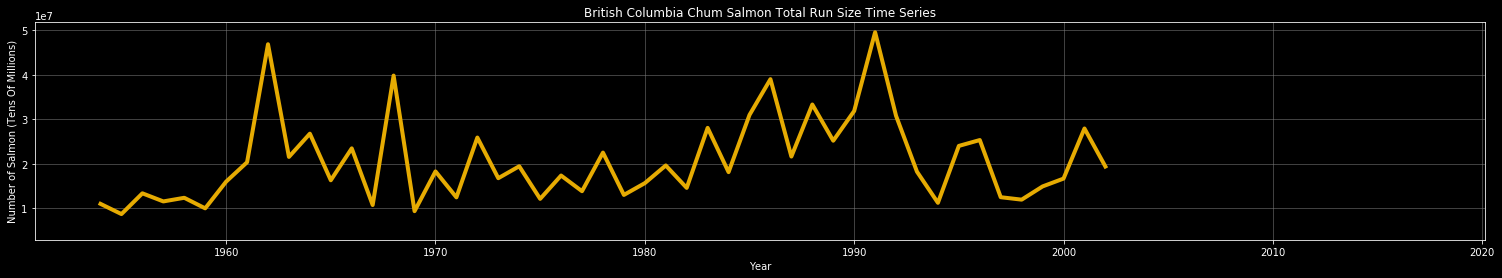

In [40]:
fish = 'Chum'
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
color = colors[5]

x_df = df.year[df.species == fish]
x_df = x_df.drop_duplicates(keep='first')

y_vals = []
for year in x_df:
    y_vals.append(df.loc[df['year'] == year, 'datavalue'].sum())

y_df = pd.DataFrame(y_vals).drop_duplicates(keep='first')

plt.style.use('dark_background')


fig, ax = plt.subplots(figsize=(26, 4))
title = "British Columbia {} Salmon Total Run Size Time Series".format(fish)
ax.set(xlabel='Year', ylabel='Number of Salmon (Tens Of Millions)', title=title)
plt.grid(color='grey', lw=0.5)
line, = ax.plot(x_df, y_df, color=color, lw=4)

def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x_df))
    return line,


def animate(i):
    line.set_data(x_df[:i], y_df[:i])
    return line,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)
writer = FFMpegWriter(fps=5, metadata=dict(artist='Connor Schultz'), bitrate=1800)
fname = "time_series/{}_ts.mp4".format(fish.replace('_',' '))
ani.save(fname, writer=writer)



